In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
import re
import nltk
import nltk.sentiment
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare
import wrangle

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from random import sample
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('npr_corpus.csv')
df.head()

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped
0,0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,it s a 2200 mile race. to give some sense of p...,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...
1,1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...
2,2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so in every team presumably there s one star o...,so in every team presumably there s one star o...,every team presumably one star one equivalent ...
3,3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,right. team ha nine riders. basically team lea...
4,4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so slipstream this is like drafting in car rac...,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?


In [3]:
df['date'] = pd.to_datetime(df.episode_date)
df['year'] = pd.DatetimeIndex(df['date']).year

### WordClouds

- Data goes from the years 1999 - 2019
- I am excluding the years 1999 - 2005. 1999 is fine, but 2001 - 2004 either have little/no values.

In [4]:
all_words = ' '.join(df.lemmatized_stopped.astype(str))

all_freq = pd.Series(all_words.split()).value_counts()

In [5]:
all_freq_df = all_freq.to_frame().reset_index()
all_freq_df.columns = ['wrd', 'cnt']

stop_words = []

for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)

In [6]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    Takes a string and removes stopwords.
    Optional arguments: 
    extra_words adds words to stopword list
    exclude_words words to keep
    '''
    # create stopword list
    stopword_list = stopwords.words('english')
    # remove excluded words
    stopword_list = set(stopword_list) - set(exclude_words)
    # add extra words
    stopword_list = stopword_list.union(set(extra_words))

    words = string.split()

    # add word to list if it's not in the stopword_list
    filtered_words = [w for w in words if w not in stopword_list]
    # join the filtered words into a string
    string_without_stopwords = ' '.join(filtered_words)
    # return list with removed stopwords
    return string_without_stopwords

In [9]:
df['a_stopwords'] = [remove_stopwords(str(u), extra_words = stop_words) for u in df.lemmatized_stopped]

all_words = ' '.join(df.a_stopwords)

KeyboardInterrupt: 

In [26]:
# 2001-2004 either contains no values or too few, so excluding Clinton's presidency and moving past to 2005

# George W. Bush [Served: 2001 - 2009] #
o_five = df.a_stopwords[df['year'] == 2005]
o_six = df.a_stopwords[df['year'] == 2006]
o_seven = df.a_stopwords[df['year'] == 2007]
o_eight = df.a_stopwords[df['year'] == 2008]
o_nine = df.a_stopwords[df['year'] == 2009]

bush = [(o_five, o_six, o_seven, o_eight, o_nine)]
bush = str(bush)


# Barack Obama [Served: 2009 - 2017] #
o_nine = df.a_stopwords[df['year'] == 2009]
twenty_ten = df.a_stopwords[df['year'] == 2010]
twenty_eleven = df.a_stopwords[df['year'] == 2011]
twenty_twelve = df.a_stopwords[df['year'] == 2012]
twenty_thirteen = df.a_stopwords[df['year'] == 2013]
twenty_fourteen = df.a_stopwords[df['year'] == 2014]
twenty_fifteen = df.a_stopwords[df['year'] == 2015]
twenty_sixteen = df.a_stopwords[df['year'] == 2016]
twenty_seventeen = df.a_stopwords[df['year'] == 2017]

obama = [(o_nine, twenty_ten, twenty_eleven, twenty_twelve, twenty_thirteen, 
          twenty_fourteen, twenty_fifteen, twenty_sixteen, twenty_seventeen)]
obama = str(obama)


# Donald J. Trump [Served: 2017 - 2021] #
twenty_seventeen = df.a_stopwords[df['year'] == 2013]
twenty_eighteen= df.a_stopwords[df['year'] == 2014]
twenty_nineteen = df.a_stopwords[df['year'] == 2015]
twenty_twenty = df.a_stopwords[df['year'] == 2016]
twenty_twentyone = df.a_stopwords[df['year'] == 2017]

trump = [(twenty_seventeen, twenty_eighteen, twenty_nineteen, twenty_twenty, twenty_twentyone)]
trump = str(trump)

In [10]:
all_words = ' '.join(df.lemmatized_stopped.astype(str))

#all_u = WordCloud(background_color = 'white', width = 1600, height = 800).generate(all_words)
#plt.imshow(all_u)
#plt.axis('off');

TypeError: Image data of dtype <U7283 cannot be converted to float

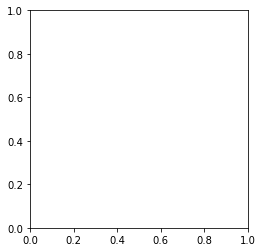

In [29]:
george_bush = ' '.join(bush)

w_bush = WordCloud(background_color = 'white', width = 1600, height = 800).generate(george_bush)
plt.imshow(str(george_bush))


barack_obama = ' '.join(obama)

b_obama = WordCloud(background_color = 'white', width = 1600, height = 800).generate(barack_obama)
plt.imshow(barack_obama)


don_trump = ' '.join(trump)

d_trump = WordCloud(background_color = 'white', width = 1600, height = 800).generate(don_trump)
plt.imshow(don_trump)
 

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5])]


axs[0].imshow(w_bush)
axs[1].imshow(b_obama)
axs[2].imshow(d_trump)


axs[0].set_title('George W. Bush (Served: 2001 - 2009)')
axs[1].set_title('Barack Obama (Served: 2009 - 2017)')
axs[2].set_title('Donald J. Trump (Served: 2017 - 2021)');


In [6]:
# obtain top 10 hosts
hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# create host df
hosts_df = df[df.speaker.isin(hosts_to_keep)]
# get episode_id of top 10 hosts
top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()

In [7]:
train, validate, test = wrangle.split_data(df)

In [8]:
# top 10 hosts
hosts_df.speaker.value_counts().head(10).index.to_list()

['NEAL CONAN, host',
 'IRA FLATOW, host',
 'FARAI CHIDEYA, host',
 'MADELEINE BRAND, host',
 'ROBERT SIEGEL, host',
 'STEVE INSKEEP, host',
 'ALEX CHADWICK, host',
 'MELISSA BLOCK, host',
 'RENEE MONTAGNE, host',
 'GUY RAZ, host']

In [ ]:
bigram = pd.Series(nltk.ngrams(all_words.split(), 2)).value_counts().head(20)
bigram